In [1]:
import pandas as pd
import numpy as np
import random
import operator
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [3]:
# Read the dataset
file_path = 'RWB_02112023195802159.csv'
data = pd.read_csv(file_path)

# Filter the dataset for 'Disposable income per capita' and 'Life expectancy at birth'
income_life_exp_data = data[data['Indicator'].isin(['Disposable income per capita', 'Life expectancy at birth'])]

# Pivot the data to have one row per region with both indicators
pivot_data = income_life_exp_data.pivot_table(index=['REG_ID', 'Regions', 'TIME', 'Time'], 
                                              columns='Indicator', 
                                              values='Value').reset_index()

# Normalize the features
scaler = MinMaxScaler()
features_to_cluster = pivot_data[['Disposable income per capita', 'Life expectancy at birth']]
normalized_features = scaler.fit_transform(features_to_cluster)
normalized_df = pd.DataFrame(normalized_features, columns=features_to_cluster.columns)


In [34]:
normalized_df

Indicator,Disposable income per capita,Life expectancy at birth
0,0.364875,0.711111
1,0.381422,0.703704
2,0.357903,0.644444
3,0.351231,0.755556
4,0.358270,0.755556
...,...,...
385,0.647735,0.637037
386,0.478299,0.303704
387,0.575244,0.644444
388,0.696057,0.518519


In [14]:
# Initialize membership matrix with random probabilities for each cluster
def initialize_membership_matrix(n, k):
    membership_mat = []
    for i in range(n):
        random_num_list = [random.random() for _ in range(k)]
        summation = sum(random_num_list)
        temp_list = [x / summation for x in random_num_list]
        membership_mat.append(temp_list)
    return membership_mat

# Calculate the centers of clusters using the membership matrix
def calculate_cluster_centers(membership_mat, df, m, k):
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = []
    for j in range(k):
        x = list(cluster_mem_val[j])
        x_raised = [e ** m for e in x]
        denominator = sum(x_raised)
        temp_num = []
        for i in range(len(df)):
            data_point = list(df.iloc[i])
            prod = [x_raised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z / denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

# Update membership values based on the cluster centers
def update_membership_values(membership_mat, cluster_centers, df, m, k):
    p = float(2 / (m - 1))
    for i in range(len(df)):
        x = list(df.iloc[i])
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(distances[j] / distances[c], p) for c in range(k)])
            membership_mat[i][j] = float(1 / den) if den != 0 else 0
    return membership_mat

# Assign data points to clusters based on maximum membership value
def get_clusters(membership_mat):
    cluster_labels = []
    for i in range(len(membership_mat)):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

# Fuzzy C-Means clustering function
def fuzzy_c_means_clustering(df, n, k, m, MAX_ITER):
    membership_mat = initialize_membership_matrix(n, k)
    curr = 0
    while curr <= MAX_ITER:
        cluster_centers = calculate_cluster_centers(membership_mat, df, m, k)
        membership_mat = update_membership_values(membership_mat, cluster_centers, df, m, k)
        cluster_labels = get_clusters(membership_mat)
        curr += 1
    return cluster_labels, cluster_centers, membership_mat

In [36]:
# Perform fuzzy C-Means clustering
k = 4  # Number of clusters
MAX_ITER = 100
n = len(normalized_df)  # Number of data points
m = 2.00  # Fuzzy parameter
labels, cluster_centers, membership_mat = fuzzy_c_means_clustering(normalized_df, n, k, m, MAX_ITER)


In [74]:
def cluster_distance(c1, c2):
    return math.sqrt((c2[1]-c1[1])**2+(c2[0]-c1[0])**2)

def find_min_clusters(clusters):
    curr_cluster_1 = 0
    curr_cluster_2 = 1
    curr_dist = -1
    for i in range(0, len(clusters)):
        for y in range(i+1, len(clusters)):
            new_dist = cluster_distance(clusters[i], clusters[y])
            if curr_dist < 0 or curr_dist > cluster_distance(clusters[i], clusters[y]):
                curr_cluster_1 = i
                curr_cluster_2 = y
                curr_dist = cluster_distance(clusters[i], clusters[y])
    return curr_cluster_1, curr_cluster_2, curr_dist

In [64]:
idxs = [[i] for i in normalized_df.index]
# idxs

In [69]:
grouping_of_clusters = []
curr_x = [x for x in normalized_df.iloc[:,0]]
curr_y = [y for y in normalized_df.iloc[:,1]]
curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
idxs = [[i] for i in normalized_df.index]
# curr_clusters

In [75]:
grouping_of_clusters = []
curr_x = [x for x in normalized_df.iloc[:,0]]
curr_y = [y for y in normalized_df.iloc[:,1]]
curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
idxs = [[i] for i in normalized_df.index]

while len(curr_clusters) > 1:
    grouping_of_clusters.append(cluster_centers)
    c1, c2, _ = find_min_clusters(curr_clusters)
    new_c = []
    new_c.append((curr_clusters[c1][0] + curr_clusters[c2][0])/2)
    new_c.append((curr_clusters[c1][1] + curr_clusters[c2][1])/2)
    curr_clusters = [curr_clusters[c] for c in range(0, len(curr_clusters)) if (c != c1 or c != c2)]
    curr_clusters.pop(c1)
    curr_clusters.pop(c2-1)
    new_indices = idxs[c1] + idxs[c2]
    idxs.pop(c1)
    idxs.pop(c2-1)
    curr_clusters.append(new_c)
    idxs.append(new_indices)
    print("curr centers", new_indices)

curr centers [167, 168]
curr centers [169, 167, 168]
curr centers [212, 213]
curr centers [124, 289]
curr centers [223, 224]
curr centers [23, 74]
curr centers [210, 297]
curr centers [301, 303]
curr centers [57, 58]
curr centers [119, 247]
curr centers [0, 86]
curr centers [231, 246]
curr centers [312, 316]
curr centers [123, 174]
curr centers [218, 236]
curr centers [217, 238]
curr centers [131, 143]
curr centers [130, 138]
curr centers [111, 201]
curr centers [64, 267]
curr centers [261, 263]
curr centers [129, 147]
curr centers [110, 183]
curr centers [117, 202]
curr centers [92, 337]
curr centers [190, 197]
curr centers [140, 186]
curr centers [29, 73]
curr centers [98, 176]
curr centers [5, 18]
curr centers [3, 36]
curr centers [72, 82]
curr centers [144, 146]
curr centers [139, 145]
curr centers [141, 130, 138]
curr centers [229, 237]
curr centers [54, 315]
curr centers [7, 331]
curr centers [242, 245]
curr centers [241, 218, 236]
curr centers [38, 144, 146]
curr centers [46, 32

curr centers [47, 262]
curr centers [124, 289, 121, 288, 287, 90, 158, 119, 247]
curr centers [161, 165]
curr centers [367, 370, 359, 368]
curr centers [231, 246, 234, 240, 229, 237, 239, 223, 224, 230, 244, 227, 241, 218, 236, 242, 245, 228, 217, 238, 235, 311]
curr centers [96, 221]
curr centers [323, 52, 49, 320]
curr centers [112, 182, 108, 164, 181]
curr centers [362, 338, 386]
curr centers [215, 226, 243]
curr centers [54, 315, 312, 316, 313, 304, 317, 222, 309, 302, 300, 314, 94, 97]
curr centers [66, 65, 259, 67, 272, 62, 63, 69]
curr centers [290, 61, 114]
curr centers [4, 3, 36, 250, 254, 159, 249, 128, 148, 126, 278, 166, 329, 120, 20, 137, 27, 133]
curr centers [21, 77, 83, 336]
curr centers [380, 356, 374]
curr centers [358, 339, 388]
curr centers [275, 115, 178, 208, 207, 277, 209, 291, 204, 256]
curr centers [79, 84, 2, 78, 30, 81, 23, 74]
curr centers [349, 361, 342, 383]
curr centers [34, 369, 364, 360, 366]
curr centers [279, 210, 297, 122, 91, 92, 337, 206, 274, 89, 

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(normalized_df, 'centroid')
Z

array([[1.67000000e+02, 1.68000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.69000000e+02, 3.90000000e+02, 0.00000000e+00, 3.00000000e+00],
       [2.12000000e+02, 2.13000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.60000000e+01, 3.46000000e+02, 5.45017750e-01, 2.00000000e+00],
       [3.50000000e+01, 7.75000000e+02, 6.25029818e-01, 3.88000000e+02],
       [7.76000000e+02, 7.77000000e+02, 6.33759953e-01, 3.90000000e+02]])

In [73]:
row_clusters = linkage(normalized_df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,212.0,213.0,0.000000,2.0
cluster 2,167.0,168.0,0.000000,2.0
cluster 3,169.0,391.0,0.000000,3.0
cluster 4,124.0,289.0,0.000033,2.0
cluster 5,223.0,224.0,0.000250,2.0
...,...,...,...,...
cluster 385,346.0,770.0,0.545018,29.0
cluster 386,767.0,769.0,0.583192,101.0
cluster 387,773.0,775.0,0.739825,323.0
cluster 388,772.0,776.0,1.000708,361.0


In [87]:
official_grouping = []
curr_x = [x for x in normalized_df.iloc[:,0]]
curr_y = [y for y in normalized_df.iloc[:,1]]
curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
idxs = [i for i in normalized_df.index]
items_per_cluster = [1 for i in range(0, len(curr_x))]

while len(curr_clusters) > 1:
    c1, c2, curr_dist = find_min_clusters(curr_clusters) # get cluster indicesx and distances
    new_c = []
    new_c.append((curr_clusters[c1][0] + curr_clusters[c2][0])/2)
    new_c.append((curr_clusters[c1][1] + curr_clusters[c2][1])/2)
    curr_clusters = [curr_clusters[c] for c in range(0, len(curr_clusters)) if (c != c1 or c != c2)]
    curr_clusters.pop(c1)
    curr_clusters.pop(c2-1)
    idxs.append(idxs[-1] + 1) # increment for new cluster
    curr_clusters.append(new_c) # add new cluster to list of clusters
    num_items = items_per_cluster[c1] + items_per_cluster[c2]
    items_per_cluster.pop(c1)
    items_per_cluster.pop(c2-1)
    items_per_cluster.append(num_items)
    official_grouping.append([idxs[c1], idxs[c2], curr_dist, num_items])
    idxs.pop(c1)
    idxs.pop(c2-1)
    print("curr centers", curr_clusters)

curr centers [[0.36487523352014944, 0.7111111111111121], [0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.3579029890

curr centers [[0.36487523352014944, 0.7111111111111121], [0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.3579029890

curr centers [[0.36487523352014944, 0.7111111111111121], [0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086

curr centers [[0.36487523352014944, 0.7111111111111121], [0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.309097277822

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.309097277822

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.309097277822

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.309097277822

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.309097277822

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35123098478783027, 0.7555555555555555], [0.35826994929276756, 0.7555555555555555], [0.36977915665866024, 0.7333333333333343], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.3662429943955164, 0.7333333333333343], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.309097277822

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.2989057912997064, 0.7555555555555555], [0.34344141980250

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.3742827595409661, 0.7925925925925927], [0.35738590872698156, 0.8074074074074078], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.2989057912997064, 0.7555555555555555], [0.34344141980250

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.3742827595409661, 0.7925925925925927], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.2989057912997064, 0.7555555555555555], [0.3434414198025087, 0.7777777777777777], [0.375967440619162

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.3742827595409661, 0.7925925925925927], [0.38080464371497197, 0.7925925925925927], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.3229583666933547, 0.7629629629629626], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.2989057912997064, 0.7555555555555555], [0.3434414198025087, 0.7777777777777777], [0.375967440619162

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.2989057912997064, 0.7555555555555555], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.3587369895916733, 0.8148148148148149], [0.4739291433146517

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.2989057912997064, 0.7555555555555555], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.3587369895916733, 0.8148148148148149], [0.4739291433146517

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.2989057912997064, 0.7555555555555555], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.3587369895916733, 0.8148148148148149], [0.4739291433146517

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.43294635708566853, 0.8074074074074078], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.2989057912997064, 0.7555555555555555], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.3587369895916733, 0.8148148148148149], [0.4739291433146517

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.3587369895916733, 0.8148148148148149], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016,

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.3090972778222578, 0.666666666666667], [0.30697891646650655, 0.7037037037037042], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.3587369895916733, 0.8148148148148149], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016,

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.30697891646650655, 0.7037037037037042], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.3587369895916733, 0.8148148148148149], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.88148148148

curr centers [[0.38142180410995463, 0.7037037037037042], [0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.30697891646650655, 0.7037037037037042], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.3587369895916733, 0.8148148148148149], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.88148148148

curr centers [[0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.30697891646650655, 0.7037037037037042], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.3587369895916733, 0.8148148148148149], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.3477115025353616, 0.859259259259

curr centers [[0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.30287563384040567, 0.6962962962962971], [0.2948025086736055, 0.681481481481482], [0.30697891646650655, 0.7037037037037042], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.31188283960501734, 0.8444444444

curr centers [[0.357902989057913, 0.6444444444444448], [0.35826994929276756, 0.7555555555555555], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.3434414198025087, 0.7777777777777777], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.31188283960501734, 0.844444444444445], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.8592592592592

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2782559380838004, 0.6888888888888891], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.31188283960501734, 0.844444444444445], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.31188283960501734, 0.844444444444445], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.562962962962963

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.53333333333333

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.53333333333333

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.42397251134240727, 0.8074074074074078], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.53333333333333

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.51111111111111

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.51111111111111

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.51111111111111

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.3944655724579664, 0.8074074074074078], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.51111111111111

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.4055911395783293, 0.7851851851851857], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06298372030958099, 0.562962962962

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.2948025086736055, 0.681481481481482], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06298372030958099, 0.562962962962

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.2966706698692287, 0.9259259259259265], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06298372030958099, 0.5629629629629633], [0.05911395783293301, 0.4740740740

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.3184881238323993, 0.8814814814814822], [0.40435681878836405, 0.8666666666666671], [0.3346510541766747, 0.85925925925926], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06298372030958099, 0.5629629629629633], [0.06565252201761408, 0.5851851851851855], [0.2365559113957833, 0.6296296296

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.40435681878836405, 0.8666666666666671], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.07914665065385641, 0.5629629629629633], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06298372030958099, 0.5629629629629633], [0.06565252201761408, 0.5851851851851855], [0.2365559113957833, 0.6296296296296298], [0.18808380037363223, 0.503703703703704], [0.1709200693888444, 0.54814814

curr centers [[0.357902989057913, 0.6444444444444448], [0.37908660261542565, 0.844444444444445], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.520082732852949, 0.4296296296296296], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.40435681878836405, 0.8666666666666671], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06565252201761408, 0.5851851851851855], [0.18808380037363223, 0.503703703703704], [0.1709200693888444, 0.5481481481481492], [0.40727582065652523, 0.7407407407407405], [0.2972044302108353, 0.6148148148148147], [0.34927942353883107, 0.65925925

curr centers [[0.37908660261542565, 0.844444444444445], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.40435681878836405, 0.8666666666666671], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06565252201761408, 0.5851851851851855], [0.18808380037363223, 0.503703703703704], [0.1709200693888444, 0.5481481481481492], [0.40727582065652523, 0.7407407407407405], [0.2972044302108353, 0.6148148148148147], [0.3036429143314652, 0.5925925925925926], [0.2619929276754737, 0.6370370370370377], [0.14573325326928208, 0.459259

curr centers [[0.37908660261542565, 0.844444444444445], [0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.40435681878836405, 0.8666666666666671], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06565252201761408, 0.5851851851851855], [0.18808380037363223, 0.503703703703704], [0.1709200693888444, 0.5481481481481492], [0.40727582065652523, 0.7407407407407405], [0.2972044302108353, 0.6148148148148147], [0.2619929276754737, 0.6370370370370377], [0.0654356818788364, 0.0740740740740744], [0.2578062449959968, 0.8962962

curr centers [[0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.4739958633573525, 0.511111111111112], [0.35686882839605016, 0.0], [0.40435681878836405, 0.8666666666666671], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06565252201761408, 0.5851851851851855], [0.1709200693888444, 0.5481481481481492], [0.40727582065652523, 0.7407407407407405], [0.2972044302108353, 0.6148148148148147], [0.2619929276754737, 0.6370370370370377], [0.0654356818788364, 0.0740740740740744], [0.2578062449959968, 0.8962962962962973], [0.35191486522551374, 0.9185185185185194], [0.31923872431278355, 1.0], [

curr centers [[0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.35686882839605016, 0.0], [0.40435681878836405, 0.8666666666666671], [0.0857185748598879, 0.5481481481481492], [0.1077028289298105, 0.5703703703703704], [0.05649519615692554, 0.5333333333333341], [0.05389311449159327, 0.511111111111112], [0.060164798505471045, 0.4518518518518526], [0.06565252201761408, 0.5851851851851855], [0.1709200693888444, 0.5481481481481492], [0.40727582065652523, 0.7407407407407405], [0.2972044302108353, 0.6148148148148147], [0.0654356818788364, 0.0740740740740744], [0.2578062449959968, 0.8962962962962973], [0.31923872431278355, 1.0], [0.20746597277822257, 0.9037037037037043], [0.1894682412596744, 0.8074074074074078], [0.40442353883106485, 0.9259259259259265],

curr centers [[0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.35686882839605016, 0.0], [0.40435681878836405, 0.8666666666666671], [0.1077028289298105, 0.5703703703703704], [0.05389311449159327, 0.511111111111112], [0.06565252201761408, 0.5851851851851855], [0.40727582065652523, 0.7407407407407405], [0.2972044302108353, 0.6148148148148147], [0.0654356818788364, 0.0740740740740744], [0.2578062449959968, 0.8962962962962973], [0.31923872431278355, 1.0], [0.20746597277822257, 0.9037037037037043], [0.40442353883106485, 0.9259259259259265], [0.14960301574593007, 0.7481481481481493], [0.11389111289031226, 0.21481481481481524], [0.08603549506271684, 0.8518518518518521], [0.08234921270349613, 0.7333333333333343], [0.15837670136108886, 0.866666666666667

curr centers [[0.5006838804376835, 0.837037037037037], [0.3522985054710435, 0.6962962962962971], [0.8107652788897786, 0.8962962962962973], [0.2748031758740326, 0.5777777777777775], [0.375967440619162, 0.6222222222222227], [0.46500533760341606, 0.7407407407407405], [0.4739291433146517, 0.4518518518518526], [0.35686882839605016, 0.0], [0.40435681878836405, 0.8666666666666671], [0.1077028289298105, 0.5703703703703704], [0.05389311449159327, 0.511111111111112], [0.06565252201761408, 0.5851851851851855], [0.40727582065652523, 0.7407407407407405], [0.0654356818788364, 0.0740740740740744], [0.2578062449959968, 0.8962962962962973], [0.31923872431278355, 1.0], [0.20746597277822257, 0.9037037037037043], [0.40442353883106485, 0.9259259259259265], [0.14960301574593007, 0.7481481481481493], [0.11389111289031226, 0.21481481481481524], [0.08603549506271684, 0.8518518518518521], [0.08234921270349613, 0.7333333333333343], [0.15837670136108886, 0.8666666666666671], [0.10198158526821458, 0.70370370370370

curr centers [[0.5006838804376835, 0.837037037037037], [0.8107652788897786, 0.8962962962962973], [0.35686882839605016, 0.0], [0.31923872431278355, 1.0], [0.08603549506271684, 0.8518518518518521], [0.3379203362690152, 0.503703703703704], [1.0, 0.3851851851851853], [0.09216539898585535, 0.7185185185185192], [0.619070256204964, 0.7129629629629632], [0.02529106618628236, 0.08796296296296335], [0.19368411395783292, 0.5099537037037045], [0.7427191753402722, 0.6888888888888893], [0.5074007122364559, 0.48657407407407466], [0.508706965572458, 0.6300925925925931], [0.20722606731218307, 0.39699074074074103], [0.5177120863357353, 0.3351851851851858], [0.4016805241067854, 0.7517650462962964], [0.0718612731982461, 0.22382812500000032], [0.32658652964037893, 0.8894820601851856], [0.6554003619562316, 0.5820891203703706], [0.1973178803459434, 0.8285590277777782], [0.31235938457797485, 0.6264286747685188], [0.08106209902818087, 0.5133101851851856], [0.10166870475547102, 0.3306712962962971]]
curr centers

In [89]:
pd.DataFrame(official_grouping, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,167,168,0.000000,2
cluster 2,169,390,0.000000,3
cluster 3,212,213,0.000000,2
cluster 4,124,289,0.000033,2
cluster 5,223,224,0.000250,2
...,...,...,...,...
cluster 385,35,770,0.351924,59
cluster 386,772,773,0.367345,329
cluster 387,16,775,0.540456,330
cluster 388,346,776,0.582397,331


In [93]:
origi = [i for i in normalized_df.index]

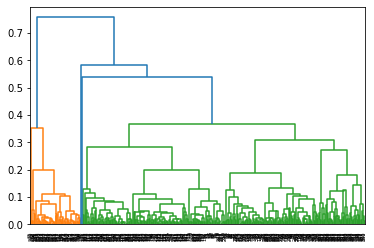

In [94]:
row_dendr = dendrogram(official_grouping, labels=origi)